In [16]:
import sys
import pandas as pd
import collections 
import os
import numpy as np
from itertools import chain
from itertools import combinations
sys.path.append('/home/jkuettel/NLP_spark/src')
sys.path.append('/home/jkuettel/NLP_spark')
from src.experiment_utils.helper_classes import token, span, repository
from definitions import ROOT_DIR
from pyannote.core import Segment


dataframe_dir = os.path.join(ROOT_DIR,'data/02_processed_to_dataframe', 'preprocessed_dataframe.pkl')
stat_df = pd.read_pickle(dataframe_dir)

#%%
test_tags = stat_df.loc['EU_32008R1099_Title_0_Chapter_0_Section_0_Article_09']
test_tags2 = stat_df.loc['EU_32006L0032_Title_0_Chapter_1_Section_0_Article_03']

from pygamma_agreement import Continuum
from pygamma_agreement import CombinedCategoricalDissimilarity
annotators = ['Alisha', 'Onerva']


In [4]:
    
dataframe_dir = os.path.join(ROOT_DIR,'data/02_processed_to_dataframe', 'preprocessed_dataframe.pkl')
#dataframe_dir = "/home/jkuettel/NLP_spark/data/02_processed_to_dataframe/preprocessed_dataframe.pkl"

stat_df = pd.read_pickle(dataframe_dir)

SyntaxError: unexpected EOF while parsing (<ipython-input-3-a7167850a3a1>, line 1)

In [ ]:
gold_tags = test_tags['Fride']
prediciton_tags = test_tags['Onerva']
gold_tokens = list(chain.from_iterable([x.tokens for x in gold_tags]))
prediciton_tokens = list(chain.from_iterable([x.tokens for x in prediciton_tags]))
common = collections.Counter(gold_tokens) & collections.Counter(prediciton_tokens)
num_same = sum(common.values())



In [ ]:
print(num_same)
print(len(prediciton_tokens))
print(len(gold_tokens))

In [ ]:
precision = 1.0 * num_same / len(prediciton_tokens)
recall = 1.0 * num_same / len(gold_tokens)
f1 = (2*precision * recall) / (precision + recall)
print(precision)
print(recall)
print(f1)


## Implementation of F1 score based on Gamma Algiment

In [18]:
continuum = Continuum()

In [19]:
continuum = Continuum()

continuum.add('X', Segment(1,3), 'a')
continuum.add('X', Segment(4,6), 'a')

#continuum.add('Y', Segment(1,6), 'a')

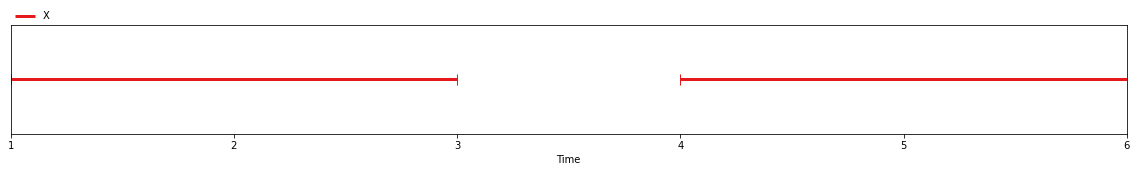

In [20]:

continuum

In [21]:
dissimilarity = CombinedCategoricalDissimilarity(continuum.categories)
best_alignment = continuum.get_best_alignment(dissimilarity)
best_alignment


AssertionError: 

In [5]:
from pygamma_agreement import Continuum, CombinedCategoricalDissimilarity
continuum = Continuum()

continuum.add('X', Segment(1,3), 'a')
continuum.add('X', Segment(2,6), 'b')
continuum.add('X', Segment(1,10), 'c')

continuum.add('Y', Segment(2,4), 'a')
continuum.add('Y', Segment(3,7), 'b')
continuum.add('Y', Segment(3,14), 'c')
continuum.add('Y', Segment(15,16), 'd')


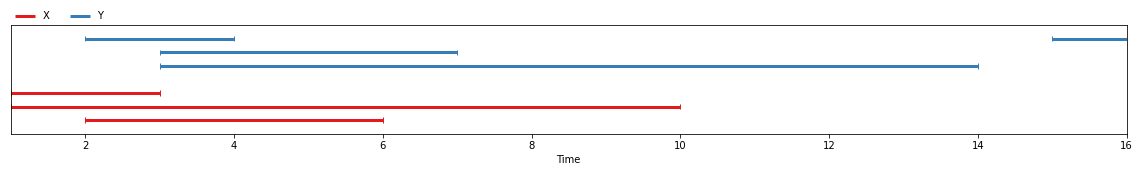

In [6]:
continuum

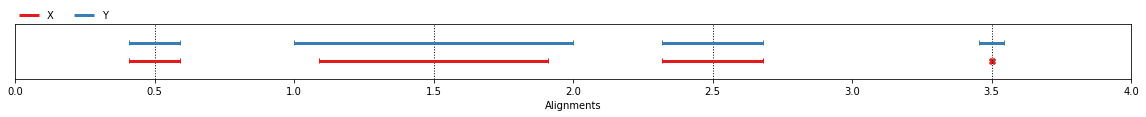

In [7]:
dissimilarity = CombinedCategoricalDissimilarity(continuum.categories)
best_alignment = continuum.get_best_alignment(dissimilarity)
best_alignment

### Function to create tuples

In [2]:
from pygamma_agreement import Continuum, CombinedCategoricalDissimilarity

def create_tuples_gamma(tag_list, category_list, alpha, beta,  cat_dissimilarity_matrix):
    continuum = Continuum()
    for taglist_tag in tag_list:
        continuum.add(taglist_tag.annotator, Segment(taglist_tag.start, taglist_tag.stop), taglist_tag.tag_)
    dissim = CombinedCategoricalDissimilarity(category_list, alpha=alpha,   beta=beta, cat_dissimilarity_matrix = cat_dissimilarity_matrix)
    best_alignment = continuum.get_best_alignment(dissim)
    
    #now retrieve tagtuples
    total_tuples = []

    for un in best_alignment.unitary_alignments: #loop over all the unitarya aligments 
        list_tuple = []
        for n_tuple in un._n_tuple: #loop over all the units in unitary aligment          
            if n_tuple[1] == None: #in case the unit is a epty unit, create a None-tag
                tuple_tag = tag(annotator = n_tuple[0])
                
            else: #in case the unit is not empty, find the tag in taglist that corresponds to this unit
                matches = [tag_ for tag_ in tag_list if tag_.annotator == n_tuple[0] and tag_.tag_ == n_tuple[1].annotation and tag_.start == n_tuple[1].segment.start and tag_.stop == n_tuple[1].segment.end]
                if len(matches) != 1:
                    raise ValueError('fuck')
                    
                tuple_tag = matches[0] #list 'matches' only contains one element
            list_tuple.append(tuple_tag)
        total_tuples.append((tuple(list_tuple))) #create tuple out of taglist and append to total tuples
    return total_tuples

In [3]:
from tag_matching import matching_methods
from scoring_functions import scoring_metrics

def get_score(tag_list, tuple_algo, scoring_metric, **optional_tuple_properties):
    """
    Calculates scoring metric based on tuple algo of taglist. Optional tuple properties related to tuple matching, e.g gamma

    """
    if not isinstance(scoring_metric, str):
        raise ValueError('scoring metric must be a string')

    if scoring_metric == 'pygamma-score':
        score = unified_gamma(tag_list, **optional_tuple_properties)
        return score

    #create tuples:
    else:
        if scoring_metric not in scoring_metrics:
            raise ValueError('This metric does not exist')

        annotators = set([tag.annotator for tag in tag_list])
        print(annotators)
        score = 0

        for annotator_pair in combinations(annotators,2):
            tag_list_annotator_pair = [tag for tag in tag_list if tag.annotator in annotator_pair]
            tag_tuples = matching_methods[tuple_algo](tag_list_annotator_pair, **optional_tuple_properties)
            score += scoring_metrics[scoring_metric] (tag_tuples)
            print(scoring_metrics[scoring_metric] (tag_tuples))
        print('len: ', len(list(combinations(annotators,2))))
        return score/len(list(combinations(annotators,2)))


In [4]:
test_set = set([1,2,3])
for ls in combinations(test_set,2):
    print(ls)

(1, 2)
(1, 3)
(2, 3)


### testing the function

In [5]:
from src.d03_inter_annotator_agreement.scoring_functions import create_scoring_matrix
from src.d03_inter_annotator_agreement.inter_annotator_agremment import keep_valid_anotations
df_annotation_marker = 4
category_list, cat_dissimilarity_matrix = create_scoring_matrix('/home/jkuettel/NLP_spark/src/experiment_utils/tag_set.json',  soft_layer_dissimilarity = True)
annotations = test_tags[df_annotation_marker:]
valid_annotations = keep_valid_anotations(annotations)


valid_annotations_flat = list(chain.from_iterable(valid_annotations))


alpha = 1
beta = 1




In [6]:
test_tags

Policy                                                     NaN
Text         article 9\r\nrenewable energy statistics and f...
Tokens       [start:0 stop:7 text:article tag_count:0, star...
Curation     [annotator:curation layer:Instrumenttypes type...
Onerva       [annotator:Onerva layer:Policydesigncharacteri...
Fride        [annotator:Fride layer:Policydesigncharacteris...
Lynn                                                       NaN
Fabian                                                     NaN
Sebastian                                                  NaN
Alisha       [annotator:Alisha layer:Instrumenttypes type:I...
Name: EU_32008R1099_Title_0_Chapter_0_Section_0_Article_09, dtype: object

In [7]:
from src.d03_inter_annotator_agreement.scoring_functions import unified_gamma, create_scoring_matrix, check_symmetric 
category_list, cat_dissimilarity_matrix = create_scoring_matrix('/home/jkuettel/NLP_spark/src/experiment_utils/tag_set.json',  soft_layer_dissimilarity = True)
alpha = 1
beta = 1  
get_score(valid_annotations_flat, tuple_algo = 'pygamma', scoring_metric='f1_exact', alpha = alpha, beta = beta, category_list = category_list, cat_dissimilarity_matrix = cat_dissimilarity_matrix)

{'Onerva', 'Alisha', 'Fride'}
0
0.15789473684210525
0.06557377049180328
len:  3


0.07448950244463619

In [8]:
print(get_score(valid_annotations_flat, tuple_algo = 'pygamma', scoring_metric='f1_exact'))

{'Onerva', 'Alisha', 'Fride'}
0
0.15789473684210525
0.06557377049180328
len:  3
0.07448950244463619


In [10]:
get_score(valid_annotations_flat, tuple_algo = 'pygamma', scoring_metric='pygamma-score')

0.0594384806536945

In [9]:
if 'hello' in test_dict:
    print('yes')

yes


In [16]:
def weird_print(a,b):
    print(a)
    print(b)
    return a*b
def better_print(a,b):
    print('this is a: ', a)
    print('this is b: ', b)
    return a*b

In [20]:
disatch = {
    'basic': weird_print,
    'better': better_print,

    
}

In [22]:
print(disatch['better'](2,3))



this is a:  2
this is b:  3
6


In [21]:
continuum = Continuum()

continuum.add('X', Segment(1,3), 'a')
continuum.add('X', Segment(2,6), 'b')
continuum.add('X', Segment(1,10), 'c')

continuum.add('Y', Segment(2,4), 'a')
continuum.add('Y', Segment(3,7), 'b')
continuum.add('Y', Segment(3,14), 'c')
continuum.add('Y', Segment(15,16), 'd')

taglist =[]
taglist.append(tag('s', type_, tag_, start, stop, text, tokens, rep)

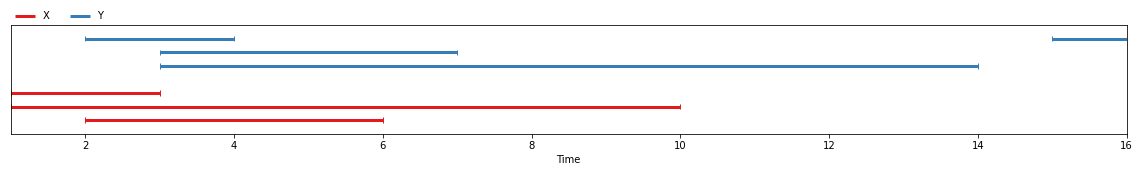

In [23]:
continuum

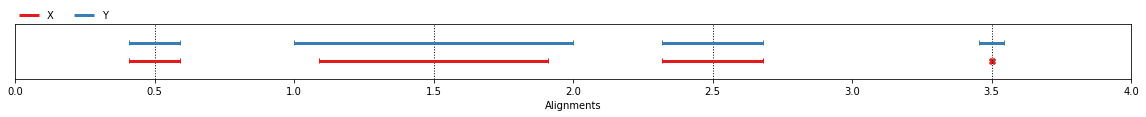

In [24]:
dissimilarity = CombinedCategoricalDissimilarity(continuum.categories)
best_alignment = continuum.get_best_alignment(dissimilarity)
best_alignment

In [31]:
dissimilarity = CombinedCategoricalDissimilarity(continuum.categories)
best_alignment = continuum.get_best_alignment(dissimilarity)
for un in best_alignment.unitary_alignments:
    
    for tuple in un._n_tuple:
        print(tuple)



('X', Unit(segment=<Segment(1, 3)>, annotation='a'))
('Y', Unit(segment=<Segment(2, 4)>, annotation='a'))
('X', Unit(segment=<Segment(1, 10)>, annotation='c'))
('Y', Unit(segment=<Segment(3, 14)>, annotation='c'))
('X', Unit(segment=<Segment(2, 6)>, annotation='b'))
('Y', Unit(segment=<Segment(3, 7)>, annotation='b'))
('X', None)
('Y', Unit(segment=<Segment(15, 16)>, annotation='d'))


In [ ]:
def F1_score(n_tuple):
    


In [64]:
un._n_tuple[0][1]


pygamma_agreement.continuum.Unit

In [30]:

sum(df_test['Tokens'].apply(len))

1097

In [6]:
df = pd.DataFrame({'num_legs': [4, 2], 'num_wings': [0, 2]},
                  index=['fox', 'eagle'])
df

,num_legs,num_wings
fox,4,0
eagle,2,2


In [23]:
for row in df.itertuples():
    print(row)

Pandas(Index='fox', num_legs=4, num_wings=0)
Pandas(Index='eagle', num_legs=2, num_wings=2)


In [21]:


continuum = Continuum()
for annotator in annotators:
    for tag in test_tags[annotator]:
        continuum.add(annotator, Segment(tag.start, tag.stop), tag.tag_)

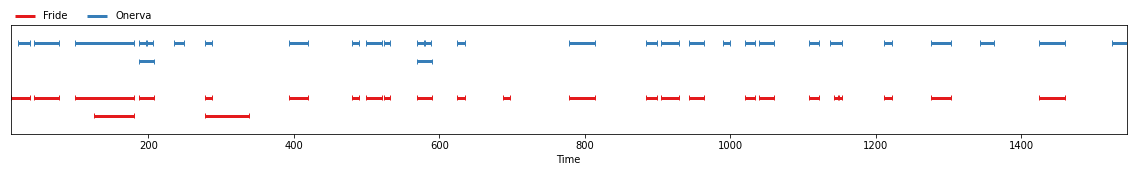

In [22]:
continuum

In [15]:

from pygamma_agreement import CombinedCategoricalDissimilarity

dissim = CombinedCategoricalDissimilarity(list(continuum.categories))
gamma_results = continuum.compute_gamma(dissim)
print(f"The gamma for that annotation is f{gamma_results.gamma}")

The gamma for that annotation is f0.21032585944345994


In [7]:
list_Fride = sorted(test_tags['Fride'], key=lambda x: x.start )
list_Onerva = sorted(test_tags['Onerva'], key=lambda x: x.start)

In [8]:
list_Onerva

[layer:Policydesigncharacteristics type:Compliance tag:Form_sanctioning start:12 stop:21 text:penalties,
 layer:Policydesigncharacteristics type:Actor tag:Authority_default start:23 stop:36 text:member states,
 layer:Instrumenttypes type:InstrumentType tag:RegulatoryInstr start:52 stop:57 text:rules,
 layer:Policydesigncharacteristics type:Compliance tag:Form_sanctioning start:61 stop:70 text:penalties,
 layer:Instrumenttypes type:InstrumentType tag:Unspecified start:186 stop:194 text:measures,
 layer:Policydesigncharacteristics type:Compliance tag:Form_sanctioning start:236 stop:245 text:penalties,
 layer:Policydesigncharacteristics type:Actor tag:Addressee_monitored start:308 stop:321 text:member states,
 layer:Policydesigncharacteristics type:Compliance tag:Form_monitoring start:328 stop:334 text:notify,
 layer:Policydesigncharacteristics type:Actor tag:Authority_monitoring start:357 stop:367 text:commission,
 layer:Policydesigncharacteristics type:Time tag:Time_Compliance start:371

In [9]:
list_Fride

[layer:Instrumenttypes type:InstrumentType tag:Unspecified start:12 stop:21 text:penalties,
 layer:Policydesigncharacteristics type:Compliance tag:Form_sanctioning start:12 stop:21 text:penalties,
 layer:Policydesigncharacteristics type:Actor tag:Authority_default start:23 stop:36 text:member states,
 layer:Instrumenttypes type:InstrumentType tag:RegulatoryInstr start:52 stop:57 text:rules,
 layer:Instrumenttypes type:InstrumentType tag:Unspecified start:61 stop:70 text:penalties,
 layer:Policydesigncharacteristics type:Compliance tag:Form_sanctioning start:61 stop:70 text:penalties,
 layer:Instrumenttypes type:InstrumentType tag:Unspecified start:111 stop:121 text:provisions,
 layer:Instrumenttypes type:InstrumentType tag:Unspecified start:186 stop:194 text:measures,
 layer:Instrumenttypes type:InstrumentType tag:Unspecified start:236 stop:245 text:penalties,
 layer:Policydesigncharacteristics type:Compliance tag:Form_sanctioning start:236 stop:245 text:penalties,
 layer:Policydesignc

In [10]:
continuum = Continuum()
for tag in list_Fride:
    continuum.add('Fride', Segment(tag.start, tag.stop), tag.tag_)
for tag in list_Onerva:
    continuum.add('Onerva', Segment(tag.start, tag.stop), tag.tag_)

In [11]:

from pygamma_agreement import CombinedCategoricalDissimilarity

dissim = CombinedCategoricalDissimilarity(list(continuum.categories), alpha=0, beta=1)
gamma_results = continuum.compute_gamma(dissim)
print(f"The gamma for that annotation is f{gamma_results.gamma}")

The gamma for that annotation is f-1.0


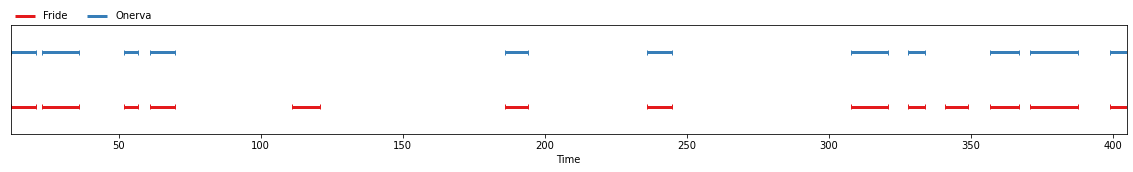

In [12]:
continuum

In [13]:
len(test_tags['Alisha'])

0

In [19]:
annotations = test_tags[4:]
type(annotations[0])

list

In [76]:
from pygamma_agreement import Continuum
from pyannote.core import Segment

In [77]:
hello = chain.from_iterable([x for x in annotations if len(x) > 0])

continuum = Continuum()

for tag in hello:
    print(hello.layer)

AttributeError: 'itertools.chain' object has no attribute 'layer'

In [63]:
ls = [0,0,3,6,9]
np.quantile(ls, 2/3, interpolation='nearest')

6

In [20]:
annotations.append('hello', ['peter'])

TypeError: cannot concatenate object of type '<class 'str'>'; only Series and DataFrame objs are valid

In [21]:
annotations_not_null = annotations[annotations.notnull()]
type(annotations_not_null)

pandas.core.series.Series

In [58]:
np.mean([len(x) for x in annotations_not_null])

4.5

In [23]:
for index, row in stat_df.iterrows():
    print(row[row.notnull()[4:]])
    print("")

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [24]:
keep_valid_anotations

NameError: name 'keep_valid_anotations' is not defined